# Multi-Agents

## Goal

We'll combine several themes from this course into a multi-agent researcher:

1) `Human In The Loop` --  A human will provide an overall topic to research. We will generate a set of AI analysts that research specific sub-topics related to the provided topic. We'll use human-in-the-loop to review and refine these sub-topics before the research phase.

2) `Sub-graphs` -- Each analyst will interview an expert on their sub-topic of focus. These interviews will be encapsulated in sub-graphs, with their own internal `messages` state, and may be multi-turn as shown in the [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb) paper.

3) `Parallelization` -- Each expert will use different knowledge gathering tools in parallel, such as search and retrieval, to answer questions from the analyst.
 
4) `Map-reduce` -- The interviews will be done in parallel using map-reduce, resulting in a multi-agent workflow. Each analyst will distill the interview into a section of the final report. These sections will be added to an overall report. A final refinement phase will be used to add an introduction and conclusion.

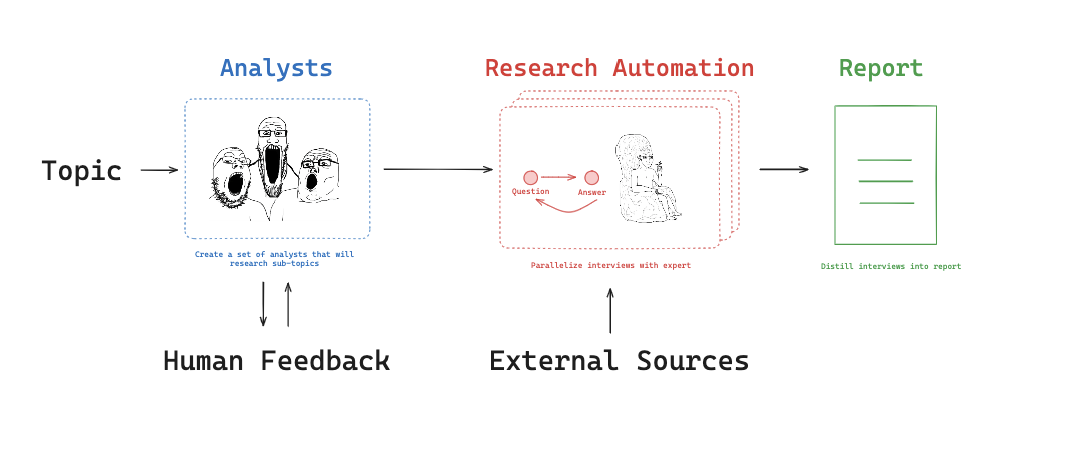

In [38]:
# !pip install -U pypdf langchain_community

## LLM

In [1]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

## State and Schemas 

In [11]:
import operator
from typing import List, Optional, Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph import MessagesState
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    final_report: str # Final report

class InterviewState(MessagesState):
    topic: str # Research topic
    max_num_turns = int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

## Generate Analysts: Human-In-The-Loop

Create analysts and review them. 

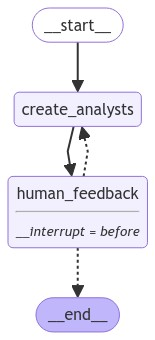

In [12]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

def create_analysts(state: ResearchGraphState):
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
    
    instructions = SystemMessage(content=f"""
    
    You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

    1. First, review the research topic:
    
    {topic}
            
    2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
            
    {human_analyst_feedback}
      
    3. Determine the most interesting themes based upon documents and / or feedback above.
                        
    4. Pick the top {max_analysts} themes.

    5. Assign one analyst to each theme.""")

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # Generate question 
    analysts = structured_llm.invoke([instructions]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: ResearchGraphState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: ResearchGraphState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [13]:
# Input
max_analysts = 3 

topic = '''I want a report focused on the innovations related to the Meta LLlama3.1 work, 
especially on training infrastructue, model architecture, and quantization approaches.'''

thread = {"configurable": {"thread_id": "3"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  # Separator line

Name: Dr. Emily Carter
Affiliation: OpenAI Research
Role: Training Infrastructure Specialist
Description: Dr. Carter focuses on the development and optimization of large-scale training infrastructures. Her primary concern is ensuring that the infrastructure can handle the computational demands of training advanced models like Meta LLlama3.1 efficiently. She is motivated by the need to reduce training time and costs while maintaining high performance.
--------------------------------------------------
Name: Dr. Rajesh Kumar
Affiliation: DeepMind
Role: Model Architecture Expert
Description: Dr. Kumar specializes in the design and evaluation of neural network architectures. His focus is on improving the efficiency and effectiveness of model architectures, particularly for large language models. He is driven by the goal of creating models that are both powerful and resource-efficient.
--------------------------------------------------
Name: Dr. Sarah Lee
Affiliation: MIT CSAIL
Role: Quanti

In [14]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [15]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef64a14-ca3f-658c-8002-c00467ef411c'}}

In [16]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  # Separator line

Name: Dr. Emily Zhang
Affiliation: Meta
Role: Lead Research Scientist
Description: Dr. Zhang focuses on the technical advancements and innovations in model architecture. She is particularly interested in how the new architectural changes in LLlama3.1 improve performance and efficiency.
--------------------------------------------------
Name: Dr. Michael Thompson
Affiliation: OpenAI
Role: AI Infrastructure Specialist
Description: Dr. Thompson specializes in the infrastructure required for training large-scale AI models. His focus is on the innovations in training infrastructure that support the development of LLlama3.1, including hardware and software optimizations.
--------------------------------------------------
Name: Sarah Lee
Affiliation: AI Startup InnovateAI
Role: Entrepreneur and AI Engineer
Description: Sarah Lee brings an entrepreneurial perspective to the discussion. She is interested in the practical applications and commercial potential of the quantization approaches used 

In [17]:
# We now update the state as if we are the human_feedback node, but supply no input to indicate that we are done
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef64a14-f644-6a9c-8004-b9aacd4bcf47'}}

In [18]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [19]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [42]:
final_state.next

()

In [20]:
analysts

[Analyst(affiliation='Meta', name='Dr. Emily Zhang', role='Lead Research Scientist', description='Dr. Zhang focuses on the technical advancements and innovations in model architecture. She is particularly interested in how the new architectural changes in LLlama3.1 improve performance and efficiency.'),
 Analyst(affiliation='OpenAI', name='Dr. Michael Thompson', role='AI Infrastructure Specialist', description='Dr. Thompson specializes in the infrastructure required for training large-scale AI models. His focus is on the innovations in training infrastructure that support the development of LLlama3.1, including hardware and software optimizations.'),
 Analyst(affiliation='AI Startup InnovateAI', name='Sarah Lee', role='Entrepreneur and AI Engineer', description='Sarah Lee brings an entrepreneurial perspective to the discussion. She is interested in the practical applications and commercial potential of the quantization approaches used in LLlama3.1, and how these innovations can be leve

## Conduct Interview

### Generate Question

The analyst will ask questions.

In [21]:
def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    instructions = SystemMessage(content=f"""
    
    You are an analyst tasked with interviewing an expert to learn about a specific topic. 

    Your goal is boil down to interesting and specific insights related to your topic.

    1. Interesting: Insights that people will find surprising or non-obvious.
            
    2. Specific: Insights that avoid generalities and include specific examples from the expert.
    
    Here is your topic of focus and set of goals: {analyst.persona}
            
    Begin by introducing yourself using a name that fits your persona, and then ask your question.

    Continue to ask questions to drill down and refine your understanding of the topic.
            
    When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

    Remember to stay in character throughout your response, reflecting the persona and goals provided to you.""")

    # Generate question 
    question = llm.invoke([instructions]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel.

Here we can be very flexible. For example, we can use:

* Specific web sites
* Indexed documents
* Web search

In [22]:
# Web sites
from langchain_community.document_loaders import WebBaseLoader
url = "https://about.fb.com/news/2024/07/open-source-ai-is-the-path-forward/"
EXPERT_DOC_CONTEXT = WebBaseLoader(url).load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [23]:
# Index (TODO: Add this to state)
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

# Load llama3.1 paper (pdf)
loader = PyPDFLoader("../assistant/docs/llama3_1.pdf")
pages = loader.load_and_split()

# Embeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# Full paper, except for references 
all_pages_except_references=pages[:100]

# Index
vectorstore = SKLearnVectorStore.from_documents(all_pages_except_references, embedding=embeddings)

# Build retriever
retriever = vectorstore.as_retriever(k=10)

In [24]:
# Web search tool

from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

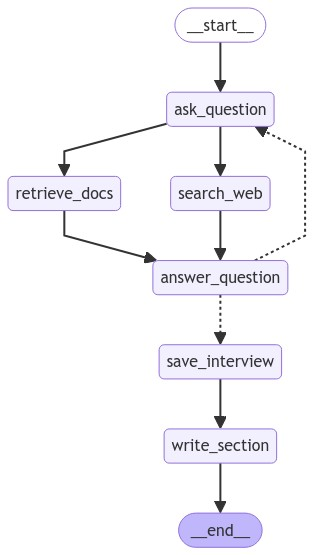

In [25]:
from langchain_core.documents import Document
from langchain_core.messages import get_buffer_string

# Search query writing
instructions = SystemMessage(content=f"""

You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def retrieve_docs(state: InterviewState):
    
    """ Get docs """

    # Enforce structured output
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([instructions]+messages)
    
    # Retrieve
    docs = retriever.invoke(search_query.search_query)

    # Format
    formatted_retrieved_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    return {"context": [formatted_retrieved_docs]} 

    formatted_retrieved_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in EXPERT_DOC_CONTEXT
        ]
    )
    
    return {"context": [formatted_retrieved_docs]} 

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Get messages
    messages = state['messages']

    # Enforce structured output
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([instructions]+messages)
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    topic = state["topic"]
    messages = state["messages"]
    context = state["context"]

    instructions = SystemMessage(content=f"""
    
    You are an expert being interviewed by an analyst who focused on learning this topic: {topic}. 
            
    You goal is to answer a question posed by the interviewer.

    To answer question, use this context:
            
    {context}

    When answering questions, follow these guidelines:
            
    1. Use only the information provided in the context. 
            
    2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

    3. The context contain sources at the topic of each individual document.

    4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

    5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
            
    6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
            
    [1] assistant/docs/llama3_1.pdf, page 7 
            
    And skip the addition of the brackets as well as the Document source preanble in your citation.""")
   
    # Answer question
    answer = llm.invoke([instructions]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    instructions = SystemMessage(content=f"""You are an expert technical writer. 
            
    Your task is to create a short, easily digestible section of a report based on a set of source documents.

    1. Analyze the content of the source documents: 
    - The name of each source document is at the start of the document, with the <Document tag.
            
    2. Create a report structure using markdown formatting:
    - Use ## for the section title
    - Use ### for sub-section headers
            
    3. Write the report following this structure:
    a. Title (## header)
    b. Summary (### header)
    c. Sources (### header)

    4. Make your title engaging based upon the focus area of the analyst: 
    {analyst.description}

    4. For the summary section:
    - Set up summary with general background / context related to the focus area of the analyst
    - Emphasize what is novel, interesting, or surprising about insights gathered from the interview
    - Create a numbered list of source documents, as you use them
    - Do not mention the names of interviewers or experts
    - Aim for approximately 400 words maximum
    - Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
            
       
    6. In the Sources section:
    - Include all sources used in your report
    - Provide full links to relevant websites or specific document paths
    - Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
    - It will look like:

    ### Sources
    [1] Link or Document name
    [2] Link or Document name

    7. Be sure to combine sources. For example this is not correct:

    [3] https://ai.meta.com/blog/meta-llama-3-1/
    [4] https://ai.meta.com/blog/meta-llama-3-1/

    There should be no redundant sources. It should simply be:

    [3] https://ai.meta.com/blog/meta-llama-3-1/
            
    8. Final review:
    - Ensure the report follows the required structure
    - Include no preamble before the title of the report
    - Check that all guidelines have been followed""")
   
    # Write section using either the gathered source docs from interview, or the interview itself 
    section = llm.invoke([instructions]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("retrieve_docs", retrieve_docs)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "retrieve_docs")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("retrieve_docs", "answer_question")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [26]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Meta', name='Dr. Emily Zhang', role='Lead Research Scientist', description='Dr. Zhang focuses on the technical advancements and innovations in model architecture. She is particularly interested in how the new architectural changes in LLlama3.1 improve performance and efficiency.')

In [27]:
from IPython.display import Markdown

# Test
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
initial_state = {"analyst": analysts[0], "messages": messages}
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke(initial_state, thread)
Markdown(interview['sections'][0])

## Llama 3.1: Advancements in Model Architecture and Performance

### Summary

The Llama 3.1 model, developed by Meta AI, represents a significant leap in the field of large language models (LLMs). This new iteration builds upon the foundation of its predecessors, introducing several key innovations that enhance both performance and efficiency. The Llama 3.1 model family includes a range of models, with the flagship model boasting 405 billion parameters and a context window of up to 128K tokens. This report delves into the architectural advancements and empirical evaluations that highlight the model's capabilities.

Llama 3.1's development focuses on three primary levers: data, scale, and managing complexity. The model is pre-trained on a massive corpus of 15 trillion multilingual tokens, a substantial increase from the 1.8 trillion tokens used for Llama 2. This extensive dataset enables the model to generalize across various tasks more effectively. The scale of training is also unprecedented, utilizing 3.8×10²⁵ FLOPs, which is nearly 50 times more than the largest version of Llama 2. The model's architecture is a dense Transformer, optimized for both pre-training and post-training stages to enhance its capabilities in coding, reasoning, and tool usage [1].

One of the most novel aspects of Llama 3.1 is its integration of multi-modal capabilities. The model can process and understand images, videos, and speech through a compositional approach, making it competitive with state-of-the-art models in these domains. This multi-modal integration is achieved by training separate encoders for each modality and then combining them with the language model [1].

Empirical evaluations demonstrate that Llama 3.1 performs comparably to leading models like GPT-4 across various benchmarks. For instance, in the ARC Challenge, Llama 3.1 achieves a normalized negative log-likelihood (NLL) per character that aligns closely with scaling law predictions, indicating its robustness and reliability [1]. Additionally, the model supports fp8 quantization, which significantly improves efficiency, making it more accessible for users with limited computational resources [2].

The post-training phase of Llama 3.1 involves instruction tuning and alignment with human feedback, incorporating millions of human instructions and preference judgments. This process ensures that the model not only understands language but also follows instructions and aligns with human preferences effectively [1].

In summary, Llama 3.1's advancements in data utilization, scale, and multi-modal integration mark it as a significant milestone in the development of large language models. Its ability to perform a wide range of tasks with high efficiency and accuracy makes it a formidable competitor in the AI landscape.

### Sources
[1] Llama 3 Herd of Models, AI @ Meta, https://llama.meta.com/  
[2] Data Science Dojo Blog, https://datasciencedojo.com/blog/meta-llama-3-1/  
[3] DataCamp Blog, https://www.datacamp.com/blog/llama-3-1-405b-meta-ai  
[4] Hugging Face Blog, https://huggingface.co/blog/llama31  
[5] The Verge, https://www.theverge.com/2024/7/23/24204055/meta-ai-llama-3-1-open-source-assistant-openai-chatgpt

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Reflection

We add a final step to reflect on the sections.

And we write an intro and conclusion. 

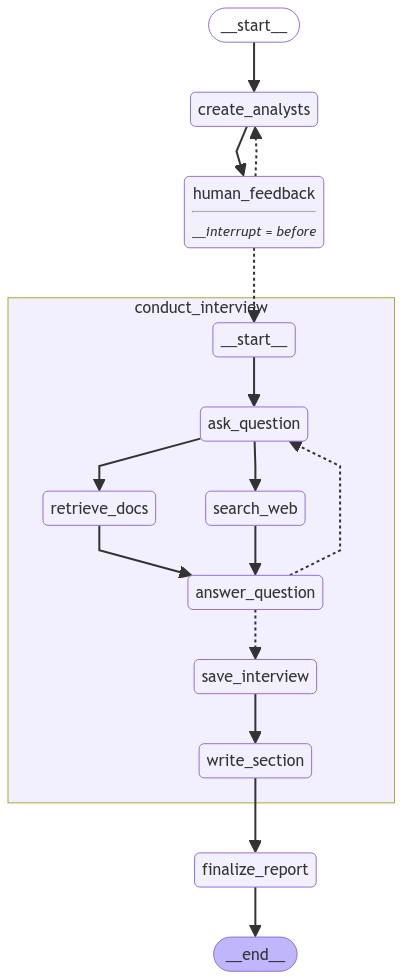

In [28]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Combine them
    formatted_str_sections = "\n\n".join([f"{section}" for i, section in enumerate(sections, start=1)])

    # Write the intro
    instructions = SystemMessage(content=f"""You are a technical writer finishing a report on {topic}
    
    You will be given the sections of the report.
    
    You job is to write a crisp and compelling introduction or conclusion section.

    The user will instruct you whether to write the introduction or conclusion.
    
    Include no pre-amble for either sectionb.
    
    Use markdown formatting. 
    
    For your introduction, create a compelling title and use the # header for the title.
    
    For your introduction, use ## Introduction as the section header. 

    For your conclusion, use ## Conclusion as the section header.
    
    Here are the sections to reflect on for writing: {formatted_str_sections}""")
   
    # Write section 
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    
    # Save full final report
    return {"final_report": intro.content + "\n\n" + formatted_str_sections + "\n\n" + conclusion.content}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [43]:
# Inputs
max_analysts = 3 

topic = '''I want a report focused on the innovations related to the Meta LLlama3.1 work, 
especially on training infrastructue, model architecture, and quantization approaches.'''

thread = {"configurable": {"thread_id": "4"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  # Separator line

Name: Dr. Emily Carter
Affiliation: OpenAI Research
Role: Training Infrastructure Specialist
Description: Dr. Carter focuses on the development and optimization of large-scale training infrastructure. Her primary concern is to ensure that the infrastructure can handle the computational demands of training advanced models like Meta LLlama3.1 efficiently. She is motivated by the need to reduce training time and costs while maintaining high performance.
--------------------------------------------------
Name: Dr. Rajesh Patel
Affiliation: DeepMind
Role: Model Architecture Expert
Description: Dr. Patel specializes in the design and innovation of neural network architectures. His focus is on improving the efficiency and effectiveness of model architectures to enhance performance and scalability. He is particularly interested in how the architectural innovations in Meta LLlama3.1 contribute to its capabilities.
--------------------------------------------------
Name: Dr. Sophia Martinez
Affi

In [44]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in the CEO of gen ai native dev tool startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef64a22-b701-6c00-8002-58e6b1b8c9db'}}

In [45]:
# We can proceed because we are happy with the analysts
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  # Separator line

Name: Dr. Emily Zhang
Affiliation: Meta
Role: Lead Research Scientist
Description: Dr. Zhang focuses on the development and optimization of training infrastructure for large-scale AI models. She is particularly interested in improving efficiency and scalability.
--------------------------------------------------
Name: Dr. Michael Thompson
Affiliation: OpenAI
Role: AI Architect
Description: Dr. Thompson specializes in model architecture, with a focus on creating innovative and efficient designs for next-generation AI systems. His work aims to balance performance with resource utilization.
--------------------------------------------------
Name: Sarah Lee
Affiliation: GenAI Tools Inc.
Role: CEO
Description: Sarah Lee is the CEO of a startup that develops generative AI tools. She is keenly interested in the practical applications of quantization approaches to make AI models more accessible and cost-effective for developers.
--------------------------------------------------


In [46]:
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef64a22-f2ab-680a-8004-881a0826c739'}}

In [47]:
# We can proceed because we are happy with the analysts
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
finalize_report


In [48]:
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Meta Llama 3.1: Revolutionizing AI with Cutting-Edge Innovations

## Introduction

The rapid evolution of artificial intelligence (AI) has been marked by significant advancements in model architecture, training infrastructure, and optimization techniques. Meta's Llama 3.1 stands at the forefront of this revolution, showcasing groundbreaking innovations that push the boundaries of what AI can achieve. This report delves into the transformative aspects of Llama 3.1, focusing on its state-of-the-art training infrastructure, pioneering model architecture, and advanced quantization approaches.

Llama 3.1 represents a monumental leap in the capabilities of foundation models, which are essential for a wide array of AI applications. With a staggering 405 billion parameters and training on 15.6 trillion tokens, Llama 3.1 exemplifies the scale and efficiency required to support next-generation AI systems. The model's integration of multimodal capabilities—encompassing image, video, and speech recognition—further enhances its versatility and performance across diverse tasks.

The innovations in Llama 3.1's training infrastructure are particularly noteworthy. Utilizing up to 16,000 H100 GPUs on Meta’s Grand Teton AI server platform, the model achieves unprecedented computational efficiency. The sophisticated network topology and load balancing techniques ensure optimal communication and resource utilization, setting new standards for AI training infrastructure.

Moreover, Llama 3.1's model architecture introduces significant enhancements, such as an expanded context window of 128K tokens and rigorous data pre-processing pipelines. These improvements enable the model to handle complex documents and deliver high-quality results in tasks requiring deep contextual understanding.

Quantization, a technique that reduces the precision of model computations, plays a crucial role in making Llama 3.1 more accessible and cost-effective. By supporting fp8 quantization, the model can run efficiently on less powerful hardware without compromising performance, democratizing access to advanced AI technologies.

In summary, Meta's Llama 3.1 is a testament to the transformative potential of innovative AI technologies. This report explores the key advancements in training infrastructure, model architecture, and quantization approaches that make Llama 3.1 a pioneering force in the AI landscape.

## Optimizing AI Training Infrastructure: Insights from Llama 3

### Summary

The development and optimization of training infrastructure for large-scale AI models is a critical area of focus for advancing artificial intelligence. Dr. Zhang's interest in improving efficiency and scalability aligns perfectly with the recent advancements presented by Meta's Llama 3 models. These models represent a significant leap in the capabilities and performance of foundation models, which are essential for a wide range of AI tasks.

Llama 3 introduces several novel and interesting aspects that are particularly relevant to Dr. Zhang's focus:

1. **Scale and Efficiency**: Llama 3's largest model boasts 405 billion parameters and is trained on 15.6 trillion tokens, utilizing 3.8×10²⁵ FLOPs, which is almost 50 times more than its predecessor, Llama 2. This massive scale is achieved using up to 16,000 H100 GPUs, each running at 700W TDP with 80GB HBM3, on Meta’s Grand Teton AI server platform [1].

2. **Multimodal Capabilities**: Llama 3 integrates image, video, and speech capabilities through a compositional approach, allowing it to perform competitively on state-of-the-art recognition tasks. This integration is achieved by training separate encoders for different modalities and combining them with the language model [1].

3. **Data Quality and Quantity**: The pre-training data for Llama 3 has been significantly improved in both quantity and quality. The model is trained on a corpus of about 15 trillion multilingual tokens, compared to 1.8 trillion tokens for Llama 2. This improvement is due to more rigorous pre-processing and curation pipelines [1].

4. **Post-Training Enhancements**: The post-training stage of Llama 3 involves supervised fine-tuning (SFT) and Direct Preference Optimization (DPO) to align the model with human preferences. This stage also incorporates safety mitigations and integrates new capabilities such as tool use, coding, and reasoning [1].

5. **Infrastructure and Network Optimization**: The training infrastructure for Llama 3 includes a sophisticated network topology with a three-layer Clos network, ensuring efficient communication between up to 24,000 GPUs. Load balancing is optimized using techniques like creating multiple network flows between GPUs to reduce traffic per flow [1].

These advancements highlight the importance of optimizing both the scale and efficiency of training infrastructure to support the development of high-quality AI models. The integration of multimodal capabilities and the focus on data quality further enhance the model's performance and applicability across various tasks.

### Sources

[1] Llama 3 Herd of Models, AI @ Meta. https://llama.meta.com/  
[2] Meta Llama 3.1 GitHub Repository. https://github.com/erik-yifei/llama3.1  
[3] Meta's Llama 3.1: Redefining Open-Source AI with Unmatched Capabilities. https://www.unite.ai/metas-llama-3-1-redefining-open-source-ai-with-unmatched-capabilities/  
[4] Meta's Llama 3.1 Outperforming the Competition. https://medium.com/@nikita04/metas-llama-3-1-outperforming-the-competition-4f44af127957

## Llama 3: Pioneering Next-Generation AI Model Architecture

### Summary

In the rapidly evolving field of artificial intelligence, foundation models serve as the backbone for a multitude of applications, ranging from natural language processing to multimodal tasks. The Llama 3 series, developed by Meta, represents a significant leap in model architecture, focusing on multilinguality, coding, reasoning, and tool usage. This report delves into the innovative aspects of Llama 3, particularly the 405B parameter model, and its implications for next-generation AI systems.

Llama 3 introduces several groundbreaking features that set it apart from its predecessors and competitors. One of the most notable advancements is the expansion of the context window to 128K tokens, a substantial increase from the 8K tokens supported by earlier models. This enhancement allows the model to handle more extensive and complex documents, making it highly suitable for tasks requiring deep contextual understanding, such as legal analysis and comprehensive research [1][2].

Another key innovation is the model's scale and data optimization. Llama 3 was pre-trained on a massive corpus of 15T multilingual tokens, significantly more than the 1.8T tokens used for Llama 2. This extensive dataset, combined with a rigorous pre-processing and curation pipeline, ensures high-quality training data, which is crucial for the model's performance [1]. The training process itself utilized 3.8×10²⁵ FLOPs, nearly 50 times more than the largest version of Llama 2, highlighting the model's computational intensity and the infrastructure required to support it [1].

Llama 3 also excels in integrating multimodal capabilities. Through a compositional approach, the model incorporates image, video, and speech recognition, performing competitively with state-of-the-art models in these domains. This integration is achieved by training separate encoders for each modality, which are then combined with the language model to enhance its versatility [1].

The empirical evaluation of Llama 3 demonstrates its superior performance across various benchmarks. For instance, the 405B model outperforms other models in tasks such as the ARC Challenge and MATH benchmarks, showcasing its advanced reasoning and problem-solving abilities [1]. Additionally, the model's ability to generate high-quality code and its proficiency in tool usage further underscore its comprehensive capabilities [1].

In summary, Llama 3 represents a significant advancement in AI model architecture, balancing performance with resource utilization. Its expanded context window, extensive training data, and multimodal integration make it a formidable tool for a wide range of applications. As the model continues to evolve, it promises to set new standards in the field of artificial intelligence.

### Sources
[1] ../assistant/docs/llama3_1.pdf  
[2] https://www.datacamp.com/blog/llama-3-1-405b-meta-ai  
[3] https://medium.com/@nikita04/metas-llama-3-1-outperforming-the-competition-4f44af127957  
[4] https://ai.meta.com/blog/meta-llama-3/  
[5] https://www.theverge.com/2024/7/23/24204055/meta-ai-llama-3-1-open-source-assistant-openai-chatgpt

## Unlocking the Potential of Quantization in Generative AI: Insights from Llama 3.1

### Summary

Generative AI models have become increasingly powerful, but their size and computational demands often limit their accessibility and cost-effectiveness. Quantization, a technique that reduces the precision of the numbers used in model computations, offers a promising solution to these challenges. This report delves into the practical applications of quantization approaches, focusing on Meta's latest release, Llama 3.1, a state-of-the-art open-source language model.

Llama 3.1 is a significant advancement in the realm of large language models (LLMs). With 405 billion parameters and a context window of up to 128K tokens, it competes with leading models like GPT-4. The model supports multilinguality, coding, reasoning, and tool usage, making it versatile for various AI tasks [1]. One of the most novel aspects of Llama 3.1 is its support for quantization, specifically fp8 quantization, which significantly enhances its efficiency and reduces computational costs [2].

Quantization in Llama 3.1 is not just a theoretical improvement but has practical implications. For instance, the model can be quantized using tools like `llama.cpp`, which simplifies the process and makes it accessible to developers [3]. This approach allows the model to run on less powerful hardware without a significant loss in performance, making advanced AI capabilities more accessible to a broader audience.

The empirical evaluations of Llama 3.1 demonstrate its competitive performance across various benchmarks, including image, video, and speech recognition tasks. The model's ability to integrate these capabilities via a compositional approach further underscores its versatility [1]. Additionally, the extensive pre-training on 15 trillion multilingual tokens and the rigorous post-training alignment with human feedback ensure that Llama 3.1 delivers high-quality results across different applications [1].

In summary, the quantization of Llama 3.1 represents a significant step towards making powerful AI models more accessible and cost-effective. By reducing the computational demands, quantization enables developers to deploy these models on a wider range of hardware, democratizing access to advanced AI technologies.

### Sources
[1] Llama 3 Herd of Models, AI @ Meta, https://llama.meta.com/  
[2] Data Science Dojo Blog, https://datasciencedojo.com/blog/meta-llama-3-1/  
[3] Demir Blog, https://blog.demir.io/quantizing-large-language-models-a-step-by-step-example-with-meta-llama-3-1-8b-instruct-model-ea96955f3fb6

## Conclusion

The advancements introduced by Meta's Llama 3.1 mark a significant milestone in the evolution of large-scale AI models. By focusing on optimizing training infrastructure, pioneering model architecture, and innovative quantization approaches, Llama 3.1 sets new standards for efficiency, scalability, and versatility in artificial intelligence.

The optimization of training infrastructure, leveraging up to 16,000 H100 GPUs and sophisticated network topologies, underscores the importance of robust and efficient computational resources. This infrastructure not only supports the massive scale of Llama 3.1 but also ensures that the model can be trained on an unprecedented volume of high-quality data, enhancing its performance across a wide range of tasks.

In terms of model architecture, Llama 3.1's expansion of the context window to 128K tokens and its integration of multimodal capabilities represent groundbreaking innovations. These features enable the model to handle complex, context-rich tasks and perform competitively in image, video, and speech recognition, thereby broadening its applicability.

The introduction of fp8 quantization in Llama 3.1 is particularly noteworthy. This approach significantly reduces computational costs and makes the model more accessible, allowing it to run efficiently on less powerful hardware without compromising performance. This democratization of advanced AI capabilities is a crucial step towards making powerful AI tools available to a broader audience.

In summary, Llama 3.1 exemplifies the cutting-edge of AI development, combining scale, efficiency, and versatility. Its innovations in training infrastructure, model architecture, and quantization not only enhance its own capabilities but also pave the way for future advancements in the field. As AI continues to evolve, the lessons learned from Llama 3.1 will undoubtedly inform and inspire the next generation of AI models.

We can look at the trace:

https://smith.langchain.com/public/8581fbe8-57ba-4a92-b452-c632da743646/r